In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True) # Присылает в формате Df
X = X.values
y = y.astype(int).values

In [3]:
X, y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784)),
 array([5, 0, 4, ..., 4, 5, 6], shape=(70000,)))

In [4]:
X = ((X / 255.) - .5) * 2

In [5]:
import matplotlib.pyplot  as plt

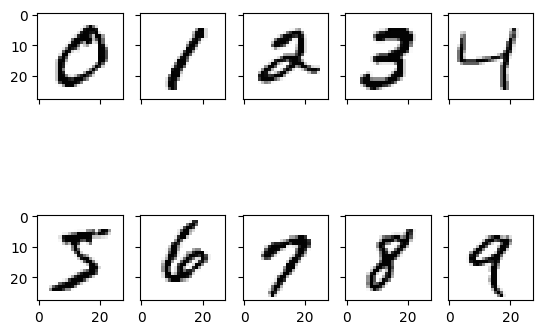

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

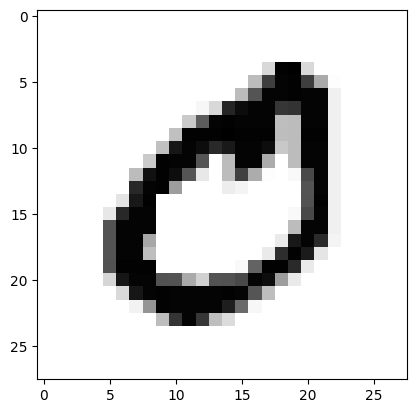

In [7]:
plt.imshow(X[y == 0][1].reshape(28, 28), cmap='Greys')

In [8]:
X[y == 0][1].reshape(28, 28)

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.    

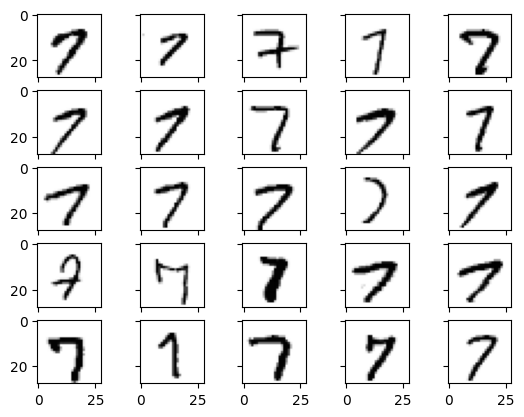

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(5*5):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

In [10]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid =  train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [11]:
import numpy as np

## Модель

In [ ]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
        
    return ary

In [48]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels)
    return np.mean((onehot_targets - probas) ** 2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [52]:
class NeuranNetMLP:
    
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes
        
        # hidden layer
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(loc=.0, scale=.1, size=[num_hidden, num_features])
        self.bias_h = np.zeros(num_hidden)
        
        #out
        self.weight_out = rng.normal(loc=.0, scale=.1, size=[num_classes, num_hidden])
        self.bias_out = np.zeros(num_classes)
        
        
    def forward(self, x):
        # Скрытый слой
        # размерность входа: [n_examples, n_features]
        # dot [n_hidden, n_features] .т
        # размерность выхода: [n_examples, n_hidden]
        
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        
        # Выходной слой
        # размерность входа: [n_examples, n_hidden]
        # dot [n_classes, n_hidden] .Т
        # размерность выхода: [n_examples, n_classes]
        
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        
        # #########################
        # Веса ВЫХОДНОГО слоя
        # #########################
        
        # унитарное кодирование
        
        y_onehot = int_to_onehot(y, self.num_classes)
        
        # Часть 1: dLoss/dOutWeights = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## для удобства повторного использования
        
        # размер входа/выхода: [n_exanples, n_classes]
        
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        
        d_a_out__d_z_out = a_out * (1. - a_out)  # сигмоидная производная
        
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        
        # градиент для выходных весов
        d_z_out__dw_out = a_h
        
        # размер входа: [n_classes, n_examples] dot [n_exanples, n_hidden]
        # размер выхода: [n_classes, n_hidden]
        
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        #######################################
        # Part 2
        # dLoss/dHiddenWeights = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dНiddenNet * dНiddenNet/dWeight
        
        d_z_out__a_h = self.weight_out
        
        # [n_classes, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # размер выхода [n_classes, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h)
        
        d_z_h__d_w_h = x
        
        # размер выхода [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
        
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)
    
model = NeuranNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [33]:
num_epochs = 50
minibatch_size = 100

def mini_batch_generator(X, y, minibatch_size):
    indicies = np.arange(X.shape[0])
    np.random.shuffle(indicies)
    
    for start_idx in range(0, indicies.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indicies[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [ ]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
mse

np.float64(0.27072877992538014)

In [72]:
int_to_onehot(y_valid, 10)[0] - probas[0]

array([-0.53928539, -0.56634271, -0.50265227, -0.42821256, -0.51012013,
        0.49018346, -0.33447845, -0.38341305, -0.71483183, -0.61796476])

In [55]:
pred_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, pred_labels)
acc * 100

np.float64(9.36)

In [47]:
X_train.shape

(55000, 784)

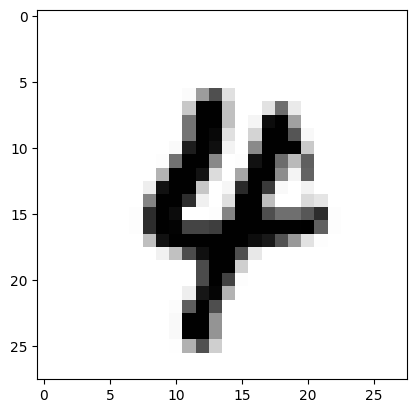

In [42]:
plt.imshow(X_train[0].reshape(28, 28), cmap='Greys')

In [43]:
import seaborn as sns

<Axes: >

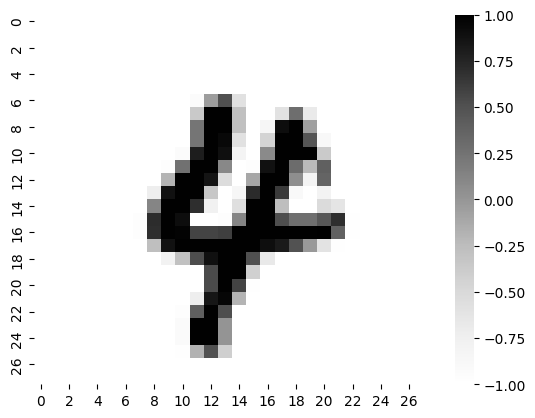

In [46]:
sns.heatmap(X_train[0].reshape(28, 28), cmap='Greys')

In [ ]:
for i in range(num_epochs):
    minibatch_gen = mini_batch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
X_train_mini.shape, y_train_mini.shape

((100, 784), (100,), [])

In [25]:
def test(x, range_val=5):
    for i in range(range_val): yield x * i
    
it = test(2)

In [31]:
next(it)

StopIteration: 

In [ ]:
inds = np.arange(10)
np.random.shuffle(inds)
inds

array([8, 4, 7, 0, 5, 6, 9, 3, 1, 2])

In [73]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = mini_batch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        pred_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (pred_labels == targets).sum()
        num_examples += targets.shape[0]
        
        mse += loss
    mse = mse/i
    acc = correct_pred / num_examples
    return mse, acc

In [76]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
f'MSE before: {mse:.1f}', f'ACC before: {acc*100:.1f}'

('MSE before: 0.3', 'ACC before: 9.4')

## Обучение

In [77]:
minibatch_size

100

In [80]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):
        minibatch_gen = mini_batch_generator(X_train, y_train, minibatch_size)
        
        for X_train_mini, y_train_mini in minibatch_gen:
            
            # forward pass
            a_h, a_out = model.forward(X_train_mini)
            
            # calculating grads
            d_loss__dw_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            
            # updating weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__dw_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        # Ведение журнала эпох, логгирование
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} ' f'| Train MSE: {train_mse:.2f}' f'| Train Acc: {train_acc:.2f}%' f'| Valid Acc: {valid_acc:.2f}%')
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc
             

In [81]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=.1)

Epoch: 001/050 | Train MSE: 0.03| Train Acc: 85.39%| Valid Acc: 84.96%
Epoch: 002/050 | Train MSE: 0.02| Train Acc: 87.91%| Valid Acc: 87.58%
Epoch: 003/050 | Train MSE: 0.02| Train Acc: 89.20%| Valid Acc: 89.06%
Epoch: 004/050 | Train MSE: 0.02| Train Acc: 90.17%| Valid Acc: 89.94%
Epoch: 005/050 | Train MSE: 0.02| Train Acc: 90.78%| Valid Acc: 90.52%
Epoch: 006/050 | Train MSE: 0.02| Train Acc: 91.10%| Valid Acc: 90.92%
Epoch: 007/050 | Train MSE: 0.02| Train Acc: 91.48%| Valid Acc: 91.04%
Epoch: 008/050 | Train MSE: 0.01| Train Acc: 91.75%| Valid Acc: 91.44%
Epoch: 009/050 | Train MSE: 0.01| Train Acc: 92.12%| Valid Acc: 91.78%
Epoch: 010/050 | Train MSE: 0.01| Train Acc: 92.30%| Valid Acc: 92.10%
Epoch: 011/050 | Train MSE: 0.01| Train Acc: 92.51%| Valid Acc: 92.28%
Epoch: 012/050 | Train MSE: 0.01| Train Acc: 92.68%| Valid Acc: 92.34%
Epoch: 013/050 | Train MSE: 0.01| Train Acc: 92.81%| Valid Acc: 92.58%
Epoch: 014/050 | Train MSE: 0.01| Train Acc: 92.97%| Valid Acc: 92.82%
Epoch:

Text(0.5, 0, 'Epocs')

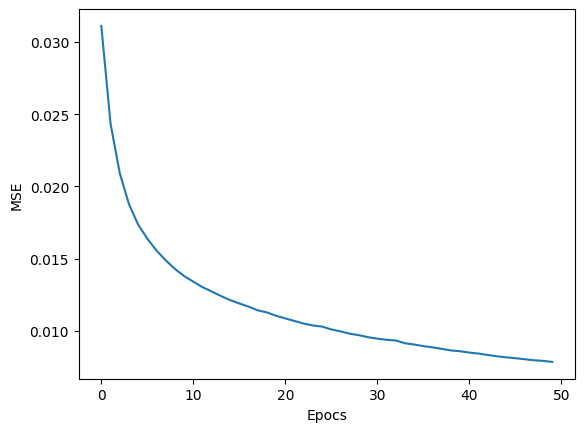

In [83]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('MSE')
plt.xlabel('Epocs')

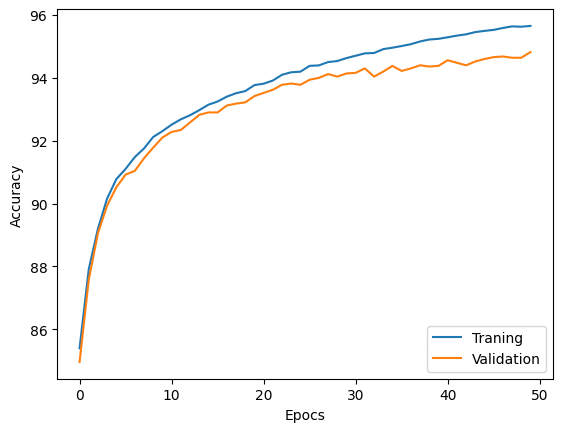

In [84]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Traning')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epocs')
plt.legend(loc='lower right')

In [85]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
f'Test accuracy: {test_acc*100:.2f}%'

'Test accuracy: 94.61%'

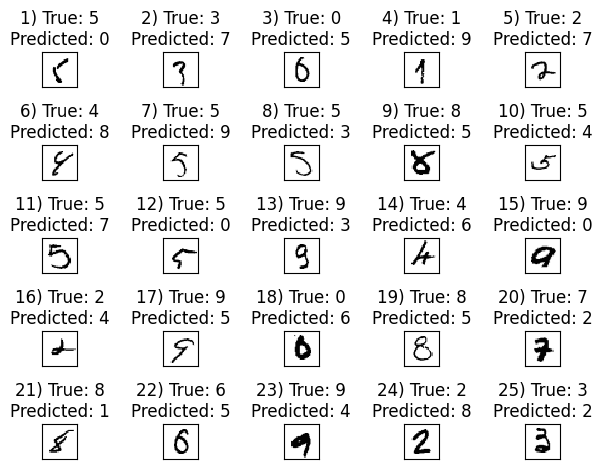

In [88]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

missclassified_images = X_test_subset[y_test_subset != test_pred][:25]
missclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    img = missclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) ' f'True: {correct_labels[i]}\n' f'Predicted: {missclassified_labels[i]}')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()